# Homework 1

I use textacy which is a lib on top of spacy to do some preprocessing.

In [1]:
# run if you dont have it installed
!pip install more_itertools

## Next cell is loading the training data disregarding NGRAM size and max vocabulary/max seq len size, it needs to be run only once

In [1]:
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy
import itertools
from operator import itemgetter 
from glob import glob
from tqdm import tqdm_notebook, tqdm
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import string
import re
import more_itertools as mit  # not built-in package
_tqdm = tqdm_notebook  # prolly you need jupyter widget for this, change for tqdm for simple tqdm

# get the training data
TRAIN_FILES_POS = glob('/home/kulikov/vlgwork/aclImdb/train/pos/*')
pos_train_texts = []
TRAIN_FILES_NEG = glob('/home/kulikov/vlgwork/aclImdb/train/neg/*')
neg_train_texts = []

# get training text in RAM
for fname in _tqdm(TRAIN_FILES_NEG):
    with open(fname, 'r') as f:
        neg_train_texts.append(f.read())
for fname in _tqdm(TRAIN_FILES_POS):
    with open(fname, 'r') as f:
        pos_train_texts.append(f.read())
        
print("Positive training samples : {} \nNegaitve training samples : {}".format(len(pos_train_texts), len(neg_train_texts)))

TRAIN_SIZE=10000  # change this if you want
                       
# Split training data on train valid parts now
pos_valid_texts = pos_train_texts[TRAIN_SIZE:]
pos_train_texts = pos_train_texts[:TRAIN_SIZE]
neg_valid_texts = neg_train_texts[TRAIN_SIZE:]
neg_train_texts = neg_train_texts[:TRAIN_SIZE]

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
TAG_RE = re.compile(r'<[^>]+>') # get rid off HTML tags from the data

def remove_tags(text):
    return TAG_RE.sub('', text)

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)] #and (token.is_stop is False)]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []

    for sample in _tqdm(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = lower_case_remove_punc(sample)
        token_dataset.append(tokens)
        all_tokens += tokens
        
    return token_dataset, all_tokens
                       
#clean from html tags
pos_valid_texts = [remove_tags(t) for t in pos_valid_texts]
neg_valid_texts = [remove_tags(t) for t in neg_valid_texts]
pos_train_texts = [remove_tags(t) for t in pos_train_texts]
neg_train_texts = [remove_tags(t) for t in neg_train_texts]

pos_valid_texts_toked, n1 =  tokenize_dataset(pos_valid_texts)
neg_valid_texts_toked, n2 =  tokenize_dataset(neg_valid_texts)
pos_train_texts_toked, n3 =  tokenize_dataset(pos_train_texts)
neg_train_texts_toked, n4 =  tokenize_dataset(neg_train_texts)
                       
voc = list(set(n1 + n2 + n3 + n4))
print('Word vocabulary size: {} words'.format(len(voc)))
                       
def find_ngrams(input_list, n):
    result_list = []
    for l in input_list:
        result_list.append(list(zip(*[l[i:] for i in range(n)])))
    return result_list


Positive training samples : 12500 
Negaitve training samples : 12500



Word vocabulary size: 92929 words


## NOW we split on ngrams, so change this accordingly

In [2]:
NGRAM = 2  # change this to make different N grams for each token
# now make train and valid dicts

train_data = {'pos': find_ngrams(pos_train_texts_toked, NGRAM),
              'neg': find_ngrams(neg_train_texts_toked, NGRAM)}
valid_data = {'pos': find_ngrams(pos_valid_texts_toked, NGRAM),
             'neg': find_ngrams(neg_valid_texts_toked, NGRAM)}

## Building vocabulary from all training data (including validation part), NOW we specify max voc size and put UNK for all rare tokens
We also keep information about frquencies in order to be able to reduce voc size later

In [3]:
max_vocab_size = 100000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

all_train_tokens = list(mit.flatten(train_data['pos'] + train_data['neg'] + valid_data['pos'] + valid_data['neg']))
counted_tokens = Counter(all_train_tokens)

vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
id2token = list(vocab)
token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
id2token = ['<pad>', '<unk>'] + id2token
token2id['<pad>'] = PAD_IDX 
token2id['<unk>'] = UNK_IDX

# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

def _text2id(doc):
    return [token2id[t] if t in token2id else UNK_IDX for t in doc]

def _id2text(vec):
    return [id2token[i] for i in vec]
    
train_data_id = {}
valid_data_id = {}

train_data_id['pos'] = []
for d in train_data['pos']:
    train_data_id['pos'].append(_text2id(d))
    
train_data_id['neg'] = []
for d in train_data['neg']:
    train_data_id['neg'].append(_text2id(d))
    
valid_data_id['pos'] = []
for d in valid_data['pos']:
    valid_data_id['pos'].append(_text2id(d))
    
valid_data_id['neg'] = []
for d in valid_data['neg']:
    valid_data_id['neg'].append(_text2id(d))
    
train_data_id_merged = []
valid_data_id_merged = []

for d in train_data_id['pos']:
    train_data_id_merged.append((d, 0))
for d in train_data_id['neg']:
    train_data_id_merged.append((d, 1))
    
for d in valid_data_id['pos']:
    valid_data_id_merged.append((d, 0))
for d in valid_data_id['neg']:
    valid_data_id_merged.append((d, 1))

Token id 43891 ; token ('some', 'suspense')
Token ('some', 'suspense'); token id 43891


## Making pytorch Dataset out of our set of dicts

In [4]:
class ImdbDataset(Dataset):
    def __init__(self, data_list, max_inp_length=None, device='cpu'):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        self.data = data_list
        self.max_len = max_inp_length
        self.data_tensors = []
        for (i, t) in tqdm_notebook(self.data):
            
            self.data_tensors.append((torch.LongTensor(i[:self.max_len]).to(device), torch.LongTensor([t]).to(device)))
              
    def __getitem__(self, key):
        (inp, tgt) = self.data_tensors[key]
        
        return inp, tgt, len(inp)

    def __len__(self):
        return len(self.data)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor
    
def batchify(batch):
    maxlen = max(batch, key = itemgetter(2))[-1]
    batch_list = []
    target_list = []
    for b in batch:
        batch_list.append(pad(b[0], maxlen, dim=0, pad=PAD_IDX))
        target_list.append(b[1])
    input_batch = torch.stack(batch_list, 0)
    target_batch = torch.stack(target_list, 0)
    
    return input_batch, target_batch

In [5]:
train_dataset = ImdbDataset(train_data_id_merged, max_inp_length=None, device='cuda')
train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

valid_dataset = ImdbDataset(valid_data_id_merged, max_inp_length=None, device='cuda')
valid_loader = DataLoader(valid_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

## Creating simple model for binary classification

In [6]:
class BagOfNGrams(nn.Module):
    def init_layers(self):
        for l in self.layers:
            if getattr(l, 'weight', None) is not None:
                torch.nn.init.xavier_uniform_(l.weight)
    
    def __init__(self, vocab_size, emb_dim=300, hidden_size=512, reduce='sum', nlayers=2, act='ReLU', nclasses=2, dropout=0.1, batch_norm=False):
        super(BagOfNGrams, self).__init__()
        self.emb_dim = emb_dim
        self.reduce = reduce
        self.nlayers = nlayers
        self.hidden_size = hidden_size
        self.nclasses = nclasses
        self.act = getattr(nn, act)
        self.embedding = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=emb_dim, mode=reduce)
        if batch_norm is True:
            self.batch_norm = nn.BatchNorm1d(self.emb_dim)
        #self.layers = nn.ModuleList([nn.Linear(self.emb_dim, 1)])
        self.layers = nn.ModuleList([nn.Linear(self.emb_dim, self.hidden_size)])
        self.layers.append(self.act())
        self.layers.append(nn.Dropout(p=dropout))
        for i in range(self.nlayers-2):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(self.act())
            self.layers.append(nn.Dropout(p=dropout))
        self.layers.append(nn.Linear(self.hidden_size, 1))
        self.init_layers()
    
    def forward(self, x):
        postemb = self.embedding(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(postemb)
        else:
            x = postemb
        for l in self.layers:
            x = l(x)
        
        return x

model = BagOfNGrams(len(id2token), emb_dim=30, hidden_size=2048, act='Tanh', nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)
model.cuda()

BagOfNGrams(
  (embedding): EmbeddingBag(100002, 30, mode=mean)
  (layers): ModuleList(
    (0): Linear(in_features=30, out_features=2048, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0)
    (3): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [7]:
learning_rate = 0.1
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.BCEWithLogitsLoss(reduction='elementwise_mean')
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, nesterov=True)
#optimizer = torch.optim.Adagrad(params=model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, labels in loader:
        outputs = torch.sigmoid(model(data))
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

train_losses = []

for epoch in range(num_epochs):
    for i, (data, labels) in _tqdm(enumerate(train_loader)): 
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        #import ipdb; ipdb.set_trace()
        loss = criterion(outputs.view(-1), labels.float().view(-1))
        loss.backward()
        
        optimizer.step()
        train_losses.append(loss.item())
        #print('Train loss: {}'.format(loss.item()))
        # validate every 100 iterations
    if epoch % 5 == 0 and epoch > 0:
        val_acc = test_model(loader=valid_loader, model=model)
        print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))


Epoch: [6/20], Step: [40/40], Train loss: 0.3021753132343292, Validation Acc: 82.52



Epoch: [11/20], Step: [40/40], Train loss: 0.0005129986093379557, Validation Acc: 87.46



Epoch: [16/20], Step: [40/40], Train loss: 7.480483327526599e-05, Validation Acc: 87.38


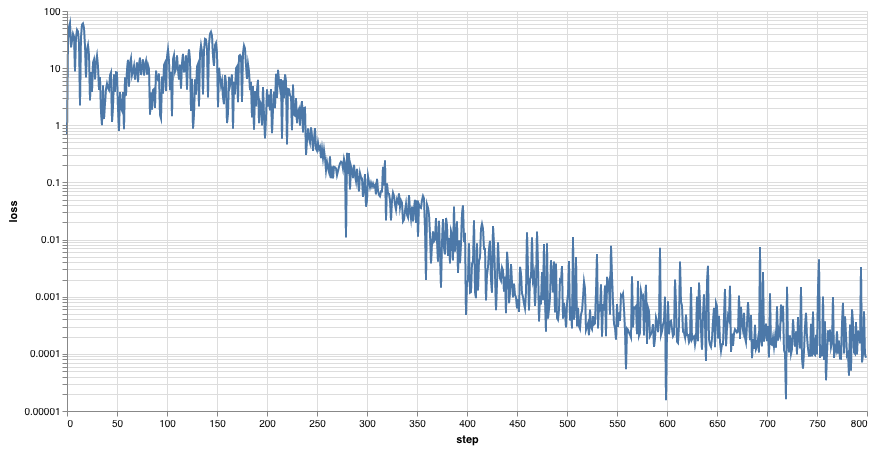

In [28]:
import altair as alt
import pandas

batch_loss = []
for i,l in enumerate(train_losses):
    batch_loss.append((i,l))

df = pandas.DataFrame(batch_loss, columns=['step', 'loss'])

alt.Chart(df).mark_line().encode(
    alt.X('step', scale=alt.Scale()),
    alt.Y('loss', scale=alt.Scale(type='log'))).properties(
        width=800,
        height=400
    )

# Test set creation

In [32]:
def find_ngrams(input_list, n):
    result_list = []
    for l in input_list:
        result_list.append([list(zip(*[l[i:] for i in range(n)])), ' '.join(l)])
    return result_list

# get the training data
TEST_FILES_POS = glob('/home/kulikov/vlgwork/aclImdb/test/pos/*')
pos_test_texts = []
TEST_FILES_NEG = glob('/home/kulikov/vlgwork/aclImdb/test/neg/*')
neg_test_texts = []

# get training text in RAM
for fname in _tqdm(TEST_FILES_NEG):
    with open(fname, 'r') as f:
        neg_test_texts.append(f.read())
for fname in _tqdm(TEST_FILES_POS):
    with open(fname, 'r') as f:
        pos_test_texts.append(f.read())
        
print("Positive training samples : {} \nNegaitve training samples : {}".format(len(pos_test_texts), len(neg_test_texts)))

#clean from html tags
pos_test_texts = [remove_tags(t) for t in pos_test_texts]
neg_test_texts = [remove_tags(t) for t in neg_test_texts]

pos_test_texts_toked, n1 =  tokenize_dataset(pos_test_texts)
neg_test_texts_toked, n2 =  tokenize_dataset(neg_test_texts)

test_data = {'pos': find_ngrams(pos_test_texts_toked, NGRAM),
              'neg': find_ngrams(neg_test_texts_toked, NGRAM)}

test_data_id = {}
test_data_id['pos'] = []
for d in test_data['pos']:
    test_data_id['pos'].append([_text2id(d[0]), d[1]])
    
test_data_id['neg'] = []
for d in test_data['neg']:
    test_data_id['neg'].append([_text2id(d[0]), d[1]])
    
test_data_id_merged = []

for d in test_data_id['pos']:
    test_data_id_merged.append((d[0], 0, d[1]))
for d in test_data_id['neg']:
    test_data_id_merged.append((d[0], 1, d[1]))


Positive training samples : 12500 
Negaitve training samples : 12500


In [33]:
class ImdbDatasetWithText(Dataset):
    def __init__(self, data_list, max_inp_length=None, device='cpu'):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        self.data = data_list
        self.max_len = max_inp_length
        self.data_tensors = []
        self.text = []
        for (i, t, text) in tqdm_notebook(self.data):
            self.data_tensors.append((torch.LongTensor(i[:self.max_len]).to(device), torch.LongTensor([t]).to(device)))
            self.text.append(text)
              
    def __getitem__(self, key):
        (inp, tgt) = self.data_tensors[key]
        text = self.text[key]
        
        return inp, tgt, len(inp), text

    def __len__(self):
        return len(self.data)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor
    
def batchify(batch):
    maxlen = max(batch, key = itemgetter(2))[-2]
    batch_list = []
    target_list = []
    text_list = []
    for b in batch:
        batch_list.append(pad(b[0], maxlen, dim=0, pad=PAD_IDX))
        target_list.append(b[1])
        text_list.append(b[3])
    input_batch = torch.stack(batch_list, 0)
    target_batch = torch.stack(target_list, 0)
    
    return input_batch, target_batch, text_list

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, labels, text in loader:
        outputs = torch.sigmoid(model(data))
        predicted = (outputs > 0.5).long()
        #import ipdb; ipdb.set_trace() # use this to get examples below
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [34]:
test_dataset = ImdbDatasetWithText(test_data_id_merged, max_inp_length=None, device='cuda')
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn=batchify, shuffle=True)

In [35]:
test_model(loader=test_loader, model=model)

88.856

## correctly predicted samples

### Positive
`it 's hard to know what to make of this weird little aussie crime flick on the one hand it 's an enjoyable little film with a great sense of humour but on the other it just lacks a certain something that ensures the film never reaches above it 's boundary that keeps it trapped within the merely interesting territory that being said two hands is a well plotted film that excellently juggles several stories at the same time which allows several small climaxes throughout the movie and that in turn helps to stop the film becoming boring the absurdity of the goings on the thick australian accents and the bizarre set of characters all help to ensure that the film entertains also the plot follows the story of a young doorman who thinks he 'll go on to bigger things after accepting a job from the local kingpin he does n't the job only lands him in trouble when he fancies a swim and stupidly leaves ten grand on the beach which is promptly stolen by a couple of kids who have the time of their lives on a shopping spree however all is not rosy for our hero who must find the money or face the consequences ... the film is made up of a cast of unknowns at least it was back in 1999 as nowadays heath ledger is something of a name he does n't impress too much here however as his performance is mostly of the one note variety and he does n't make for a very compelling lead he fits the movie in that he 's australian and looks naive but beyond that he 's not the best lead i 've ever seen in a movie if you ask me bryan brown gave the best performance here he might not have a great deal of screen time but he steals every scene he 's in and it 's him that provides the movie with a lot of its humour he 's got nothing to do with the best sequence however which takes place in the form of probably the most hilarious bank robbery ever caught on film on the whole i can recommend this film to people that enjoy quirky crime films as the weirdness is plentiful and the way that events take a turn for the bizarre is enjoyable but if you 're not a fan of this sort of film i ca n't really say that two hands will float your boat it 's not a must see but if it 's your thing and you get a chance to see it ... you probably wo nt completely regret it`

### Positive
`sally and saint anne is a very funny movie the first time my mom told me about it i was 7 and saint anne had just been the saint i had for my communion saint my mom knew this so she told me to watch this with her i did and have seen it many times since because it is really funny aunt bea from the andy griffith show was in it and sally 's grandfather was the guy who played santa claus in miracle on 34th street so there were lots of actors we seen on tv shows too there is a bad guy who keeps trying to steal the house away and sally keeps trying things with st. anne to help raise money so they can keep the house that includes a boxing match with hugh o'brian who plays her older brother this is a good and funny movie that i still love`

### Negative
`unless there 's some huge ironic conspiracy going on my jaw dropped when i read the positive reviews of this film i can not believe that this film was even released it 's so bad i admit it is not my kind of movie but i tried to watch it objectively anyway you know so bad it 's funny and was still offended at its sheer awfulness the acting is atrocious they ca n't have watched the rushes and i 'm guessing there was one take per scene it really is that terrible it is the worst film i have seen in many a year in fact i would n't even call it a film it 's a tragedy the gay black friend whom no one actually calls gay it 's just implied because he 's so crazy homophobic this is not good in fact this is downright vomit inducing the jokes die on their pathetic arses the music is so bad it defies belief the person who compiled the soundtrack essentially chose the most ear mutilatingly bad songs they had ever heard and put them in this waste of film stock oh my good christ i ca n't believe the 80 's produced utter garbage like this i grew up through them and i can not find one thing worth of note here it must have been a dark time to be a cinema goer if you even contemplate watching this film go see a psychiatrist he will then accordingly slap you you sick sick person`

## incorrectly predicted samples

### Positive (predicted as negative)
`ok when i rented this several years ago i had the worst expectations yes the acting is n't great and the picture itself looks dated but as i sat there a strange thing happened i started to like it the action is great and there are few scenes that make you jump brion james maybe one of the greatest b grade actors next to bruce campbell is great as always the story is n't bad either now i would n't rush out and buy it but you wo n't waste your time at least watching this good b grade post apocalyptic western`

### Negative (predicted as positive)
`i first saw this movie at a saturday matinee when i was very young i thought it was cool and often thought about it well i finally resaw it on dvd it was still very entertaining but in a different way it has to rank as one of the goofiest campiest 1950 's sci fi movies it seemed filled with stock military footage the dialogue is stilted and effects are crude there is one line of dialogue that had me in stitches the line jeff morrow says while on the beach with the babe rent it if you need a movie to watch with a bunch of drunken friends it is a classic`

### Positive (predicted as negative)
`look ... i\'ve come to expect this level of acting from william macy ... the guy just keeps putting in terrific performances ... but meat loaf just when did his loafness decide to leave jim steinman behind and throw his decidedly lower weight around in the wonderful world of stanislavsky well ... what can i say i \'m duly impressed to paraphrase an old adage it ai n\'t the meat it \'s the emotion" ... and the loaf is quietly buffing up his acting chops of late .. laura dern carries off the 40 \'s look perfectly here ... great job by the costume and hair departments ... david paymer is typecast but right on the money solid camera work throughout the flick the plot line is reminiscent of gentleman \'s agreement post wwii anti semitism well worth your time ... particularly for the growing legions of bill macy acolytes`